# Regresión logística

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

In [29]:
from sklearn.model_selection import GridSearchCV

In [30]:
from mls import *
from prepro import pprint, prepro

In [31]:
from imblearn.pipeline import Pipeline as pipeline_sampler
from imblearn.over_sampling import ADASYN

Las funciones utilizadas en este notebook se encuentran en los archivos prepro.py y mls.py

In [32]:
df=(prepro(path='data.xlsx',n=10,info=False).pipe(seleccion))

El dataset contiene 514 filas y 21 columnas


In [33]:
pprint(df.head(),'',2)

,SEXO,PSNR,SUBTIPO,MRSS,RAYNAUD,ULCERAS,DISCROMIAS,ROCES_TENDINOSOS,CONTRACTURAS_FLEX,ARTRITIS,EPID,HAP,CRISIS_RENAL,AESOFAGICA,AGASTRICA,AINTESTINAL,PERDIDA_PESO,ANEMIA,EDAD_DEBUT,EXITUS5,CFC
0,0,Endurecimiento piel,0,6,0,0,0,0,1,0,0,0,0,1,0,0,1,1,66,1,CF2
1,0,Endurecimiento piel,0,24,1,1,0,1,0,0,0,0,0,0,0,0,0,1,66,1,CF2
2,0,Puffy hand,1,2,1,0,0,0,0,0,0,1,0,1,0,0,0,0,74,1,CF2
3,1,Endurecimiento piel,0,29,0,0,1,0,1,0,0,0,1,1,0,0,1,1,58,1,CF2
4,1,Puffy hand,0,16,0,0,1,1,0,0,0,0,0,1,0,0,0,0,67,1,CF3-4


In [34]:
y=df.exitus5
x=df.drop(columns='exitus5')
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,stratify=y)

## Regresion logística con regularización

In [35]:
prepro = ColumnTransformer(
    transformers=[
        ("scaler", StandardScaler(), x._get_numeric_data().columns),
        ("encoder", OneHotEncoder(handle_unknown="ignore"), ['CFc','PSNR'])],
    remainder='passthrough',verbose_feature_names_out=False)

In [36]:
logitmod = Pipeline(steps=[("prepro", prepro), 
           ("logit", LogisticRegression(penalty='l2'))])

In [37]:
params={'logit__C':[.005,.01,.05],
        'logit__solver':['lbfgs','liblinear']}      

In [38]:
grid = GridSearchCV(estimator = logitmod, 
                   param_grid = params, 
                   scoring = 'recall',
                   verbose = 0)

In [39]:
grid.fit(xtrain,ytrain)

GridSearchCV(estimator=Pipeline(steps=[('prepro',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         Index(['mRSS', 'edad_debut'], dtype='object')),
                                                                        ('encoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['CFc',
                                                                          'PSNR'])],
                                                          verbose_feature_names_out=False)),
                                       ('logit', LogisticRegression())]),
             param_grid={'logit__C': [0.005, 0.01, 0.05],
                         'logit__solver': ['lbfgs', 'liblinear']},
             scoring='recall')

In [40]:
pd.DataFrame(grid.cv_results_).iloc[:,6:-1]

,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
0,"{'logit__C': 0.005, 'logit__solver': 'lbfgs'}",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"{'logit__C': 0.005, 'logit__solver': 'liblinear'}",0.200000,0.071429,0.142857,0.142857,0.357143,0.182857,0.096214
2,"{'logit__C': 0.01, 'logit__solver': 'lbfgs'}",0.000000,0.000000,0.000000,0.142857,0.071429,0.042857,0.057143
3,"{'logit__C': 0.01, 'logit__solver': 'liblinear'}",0.200000,0.214286,0.285714,0.357143,0.428571,0.297143,0.086378
4,"{'logit__C': 0.05, 'logit__solver': 'lbfgs'}",0.333333,0.357143,0.571429,0.500000,0.285714,0.409524,0.107960
5,"{'logit__C': 0.05, 'logit__solver': 'liblinear'}",0.266667,0.500000,0.571429,0.500000,0.428571,0.453333,0.103692


In [41]:
mejor=best_grid(grid,xtrain,ytrain)

Mejor score: 0.4533333333333333
Mejores parametros: {'logit__C': 0.05, 'logit__solver': 'liblinear'}
Ajustando el mejor modelo...


In [42]:
coefi(mejor,'logit').pipe(pprint,'RLog',2)

,COEFICIENTES
Variable,
mRSS,"0,79"
CFc_CF1,"-0,56"
edad_debut,"0,52"
EPID,"-0,24"
CFc_CF2,"-0,23"
PSNR_Otros,"-0,22"
contracturas_flex,"-0,21"
PSNR_Articular,"-0,19"
raynaud,"-0,18"


============= Report classification ==============

Sensibilidad del train: 0.48
Sensibilidad del test: 0.33

              precision    recall  f1-score   support

          No       0.87      0.95      0.91        85
          Si       0.60      0.33      0.43        18

    accuracy                           0.84       103
   macro avg       0.74      0.64      0.67       103
weighted avg       0.82      0.84      0.83       103


========= Confusion matrix train vs test =========



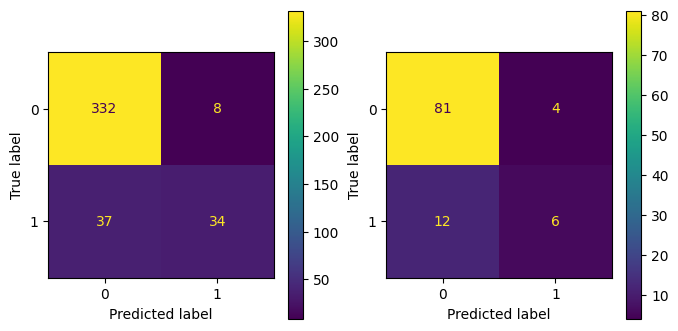

In [43]:
metricas(mejor,xtrain,ytrain,xtest,ytest)

## Regresion logística con regularicación y pesos ponderados

In [57]:
logitmod = Pipeline(steps=[("prepro", prepro), 
           ("logit", LogisticRegression(penalty='l2',class_weight="balanced"))])

params={'logit__C':[.005,.01,.05],
        'logit__solver':['lbfgs','liblinear']} 

grid = GridSearchCV(estimator = logitmod, 
                   param_grid = params, 
                   scoring = 'recall',
                   verbose = 0)
grid.fit(xtrain,ytrain)
mejor=best_grid(grid,xtrain,ytrain)
mejor.fit(xtrain,ytrain)

Mejor score: 0.8047619047619048
Mejores parametros: {'logit__C': 0.005, 'logit__solver': 'liblinear'}
Ajustando el mejor modelo...


Pipeline(steps=[('prepro',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  Index(['mRSS', 'edad_debut'], dtype='object')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['CFc', 'PSNR'])],
                                   verbose_feature_names_out=False)),
                ('logit',
                 LogisticRegression(C=0.005, class_weight='balanced',
                                    solver='liblinear'))])

In [58]:
coefi(mejor,'logit').pipe(pprint,'RLog + pesos ponderados',2)

,COEFICIENTES
Variable,
mRSS,"0,35"
edad_debut,"0,23"
CFc_CF1,"-0,14"
discromias,"0,10"
sexo,"0,05"
Aesofagica,"0,05"
PSNR_Endurecimiento piel,"0,04"
PSNR_Otros,"-0,04"
PSNR_Articular,"-0,04"


============= Report classification ==============

Sensibilidad del train: 0.83
Sensibilidad del test: 0.89

              precision    recall  f1-score   support

          No       0.97      0.68      0.80        85
          Si       0.37      0.89      0.52        18

    accuracy                           0.72       103
   macro avg       0.67      0.79      0.66       103
weighted avg       0.86      0.72      0.75       103


========= Confusion matrix train vs test =========



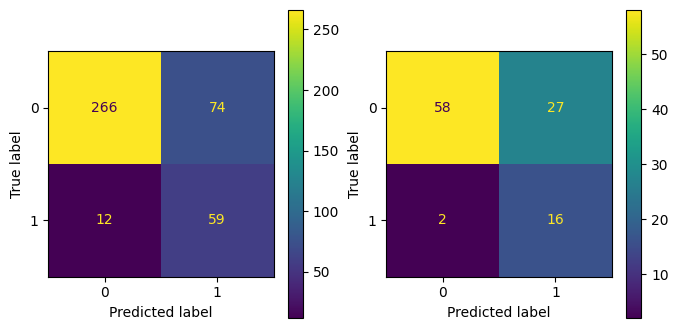

In [59]:
metricas(mejor,xtrain,ytrain,xtest,ytest)

## Regresion logista con over sampling de clase minoritaria

In [47]:
y.value_counts()

exitus5
0    425
1     89
Name: count, dtype: int64

In [54]:
logitmod = pipeline_sampler(steps=[("prepro", prepro),
                            ('sampler',ADASYN()),
                             ("logit", LogisticRegression(penalty='l2'))])

params={'sampler__sampling_strategy':[.5,.7,.9],
        'sampler__n_neighbors':[3,5,7,10],
       'logit__C':[.005,.01,.05],
       'logit__solver':['lbfgs','liblinear']}

grid = GridSearchCV(estimator = logitmod, 
                   param_grid = params, 
                   scoring = 'recall',
                   verbose = 0)
grid.fit(xtrain,ytrain)
mejor=best_grid(grid,xtrain,ytrain)
mejor.fit(xtrain,ytrain)

Mejor score: 0.8047619047619048
Mejores parametros: {'logit__C': 0.005, 'logit__solver': 'liblinear', 'sampler__n_neighbors': 7, 'sampler__sampling_strategy': 0.9}
Ajustando el mejor modelo...


Pipeline(steps=[('prepro',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  Index(['mRSS', 'edad_debut'], dtype='object')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['CFc', 'PSNR'])],
                                   verbose_feature_names_out=False)),
                ('sampler', ADASYN(n_neighbors=7, sampling_strategy=0.9)),
                ('logit', LogisticRegression(C=0.005, solver='liblinear'))])

In [55]:
coefi(mejor,'logit').pipe(pprint,'RLog + oversampling',2)

,COEFICIENTES
Variable,
mRSS,"0,36"
edad_debut,"0,31"
CFc_CF1,"-0,21"
discromias,"0,14"
Aesofagica,"0,08"
PSNR_Endurecimiento piel,"0,07"
sexo,"0,07"
CFc_CF3-4,"0,06"
PSNR_Articular,"-0,06"


============= Report classification ==============

Sensibilidad del train: 0.83
Sensibilidad del test: 0.89

              precision    recall  f1-score   support

          No       0.97      0.69      0.81        85
          Si       0.38      0.89      0.53        18

    accuracy                           0.73       103
   macro avg       0.67      0.79      0.67       103
weighted avg       0.86      0.73      0.76       103


========= Confusion matrix train vs test =========



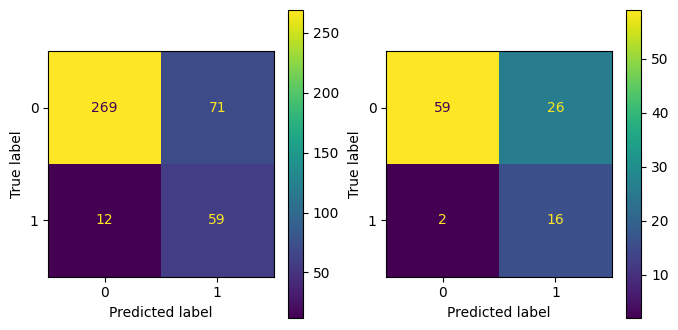

In [56]:
metricas(mejor,xtrain,ytrain,xtest,ytest)